In [12]:
# Step 1: Load and clean CRSP data
import pandas as pd

# 1) Read CRSP (CSV or ZIP) and parse dates
#   —change filename if you have the ZIP version.
crsp = pd.read_csv(
    'crsp_1926_2020.csv',
    parse_dates=['date'],
    dtype={'SHRCD': 'Int64', 'EXCHCD': 'Int64'}
)

# 2) Keep only ordinary/common shares (SHRCD = 10 or 11)
crsp = crsp[crsp['SHRCD'].isin([10, 11])].copy()

# 3) Drop rows missing returns or price/outstanding
crsp = crsp.dropna(subset=['RET', 'PRC', 'SHROUT'])

# 4) Compute market equity (in millions)
crsp['ME'] = (crsp['PRC'].abs() * crsp['SHROUT']) / 1000

# 5) Create a Month index for grouping
crsp['month'] = crsp['date'].dt.to_period('M').dt.to_timestamp()

# Quick check
print(crsp[['date','month','PERMNO','RET','ME']].head())


        date      month  PERMNO        RET         ME
1 1986-01-31 1986-01-01   10000          C  16.100000
2 1986-02-28 1986-02-01   10000  -0.257143  11.960000
3 1986-03-31 1986-03-01   10000   0.365385  16.330000
4 1986-04-30 1986-04-01   10000  -0.098592  15.172000
5 1986-05-30 1986-05-01   10000  -0.222656  11.793878


In [13]:
# Step 2: Load *both* blocks of Best-Companies data
import pandas as pd

# 1) Read both blocks (header is on the second row: header=1)
df = pd.read_excel(
    'bcwlist.xlsx',     # or 'bcwlist.xls'
    sheet_name=0,
    header=2,           # use row 1 (0-based) as column names
    usecols="A:D,F:I"   # grab A–D (first block) and F–I (second block)
)

# 2) Rename the 8 columns to distinguish blocks
df.columns = [
    'Rank1','Company1','PERMNO1','Year1',
    'Rank2','Company2','PERMNO2','Year2'
]

# 3) Slice out each block, rename to a common schema, and concat
df1 = (
    df[['Rank1','Company1','PERMNO1','Year1']]
    .rename(columns={
      'Rank1':'Rank','Company1':'Company',
      'PERMNO1':'PERMNO','Year1':'Year'
    })
)
df2 = (
    df[['Rank2','Company2','PERMNO2','Year2']]
    .rename(columns={
      'Rank2':'Rank','Company2':'Company',
      'PERMNO2':'PERMNO','Year2':'Year'
    })
)
bcw = pd.concat([df1, df2], ignore_index=True)

# 4) Clean and type‐cast
bcw = bcw.dropna(subset=['Year','PERMNO'])
bcw['Year']   = bcw['Year'].astype(int)
bcw['PERMNO'] = bcw['PERMNO'].astype(int)

# 5) Build your dict: { year → [permno, …] }
bcw_lists = bcw.groupby('Year')['PERMNO'].apply(list).to_dict()

# Inspect a few years
for y, permnos in sorted(bcw_lists.items())[:3]:
    print(f"{y}: {permnos[:5]} …")


1984: [22592, 54391, 61241, 60871, 59184] …
1993: [22592, 54391, 61241, 26470, 59184] …
1998: [22592, 54391, 20117, 75510, 26470] …


In [14]:
# Step 3 & 4: Define your portfolio formation schedule
import pandas as pd

# bcw_lists should already be defined as { Year: [permno, …], … }
periods = []

for year in sorted(bcw_lists.keys()):
    if year == 1984:
        # Edmans: form 4/1984, hold through 2/1993
        start = pd.Timestamp('1984-04-01')
        end   = pd.Timestamp('1993-02-01')
    elif year == 1993:
        # Edmans: form 3/1993, hold through 1/1998
        start = pd.Timestamp('1993-03-01')
        end   = pd.Timestamp('1998-01-01')
    elif year >= 1998:
        # From 1998 on: assume released Jan 1, form Feb 1, hold til Jan 1 next year
        start = pd.Timestamp(f'{year}-02-01')
        # If your CRSP ends Dec 2020, the 2020 period will naturally truncate at 2020-12
        end   = pd.Timestamp(f'{year+1}-01-01')
    else:
        # no list published in other years
        continue

    periods.append({
        'Year':   year,
        'start':  start,
        'end':    end,
        'permnos': bcw_lists[year]
    })

# Convert to DataFrame for easy inspection
periods_df = pd.DataFrame(periods)
print(periods_df[['Year','start','end']])


    Year      start        end
0   1984 1984-04-01 1993-02-01
1   1993 1993-03-01 1998-01-01
2   1998 1998-02-01 1999-01-01
3   1999 1999-02-01 2000-01-01
4   2000 2000-02-01 2001-01-01
5   2001 2001-02-01 2002-01-01
6   2002 2002-02-01 2003-01-01
7   2003 2003-02-01 2004-01-01
8   2004 2004-02-01 2005-01-01
9   2005 2005-02-01 2006-01-01
10  2006 2006-02-01 2007-01-01
11  2007 2007-02-01 2008-01-01
12  2008 2008-02-01 2009-01-01
13  2009 2009-02-01 2010-01-01
14  2010 2010-02-01 2011-01-01
15  2011 2011-02-01 2012-01-01
16  2012 2012-02-01 2013-01-01
17  2013 2013-02-01 2014-01-01
18  2014 2014-02-01 2015-01-01
19  2015 2015-02-01 2016-01-01
20  2016 2016-02-01 2017-01-01
21  2017 2017-02-01 2018-01-01
22  2018 2018-02-01 2019-01-01
23  2019 2019-02-01 2020-01-01
24  2020 2020-02-01 2021-01-01


In [15]:
import pandas as pd
from pandas.tseries.offsets import MonthBegin

def make_portfolio_returns(
    crsp: pd.DataFrame,
    permnos: list[int],
    start: pd.Timestamp,
    end: pd.Timestamp,
    equal: bool = True
) -> pd.Series:
    """
    Build monthly returns for permnos between start and end.
    - Coerce RET & ME to float
    - IPOs: add one month after first appearance
    - Delistings: RET=0 then remove next month + rebalance
    """
    # 1) Subset
    mask = (crsp['month'] >= start) & (crsp['month'] <= end)
    sub  = crsp.loc[mask, ['month','PERMNO','RET','ME']].copy()

    # 2) Ensure numeric
    sub['RET'] = pd.to_numeric(sub['RET'], errors='coerce')
    sub['ME']  = pd.to_numeric(sub['ME'],  errors='coerce')

    # 3) Pivot using pivot_table + first to avoid lists
    rets = sub.pivot_table(
        index='month',
        columns='PERMNO',
        values='RET',
        aggfunc='first'
    )
    mes = sub.pivot_table(
        index='month',
        columns='PERMNO',
        values='ME',
        aggfunc='first'
    )

    # 4) Record first/last appearance
    first_month = sub.groupby('PERMNO')['month'].min().to_dict()
    last_month  = sub.groupby('PERMNO')['month'].max().to_dict()

    # 5) Build month index only where we have data
    desired = pd.date_range(start=start, end=end, freq='MS')
    months  = [m for m in desired if m in rets.index]

    # 6) Initialize active & weights
    active = {p for p in permnos if first_month.get(p, pd.Timestamp.max) <= start}
    if equal:
        w = {p: 1/len(active) for p in active}
    else:
        me0 = mes.loc[months[0], list(active)]
        w = {p: me0[p]/me0.sum() for p in active}

    port_rets = []
    rebalance = False

    # 7) Loop over available months
    for i, m in enumerate(months):
        # a) full rebalance if flagged or at first month
        if i == 0 or rebalance:
            if equal:
                w = {p: 1/len(active) for p in active}
            else:
                mem = mes.loc[m, list(active)]
                w = {p: mem[p]/mem.sum() for p in active}
            rebalance = False

        # b) Get returns (delistings → 0)
        r = rets.loc[m, list(active)].fillna(0)

        # c) Portfolio return
        p_ret = sum(w[p] * r[p] for p in active)
        port_rets.append((m, p_ret))

        # d) Drift weights
        w = {p: w[p] * (1 + r[p]) for p in active}
        total = sum(w.values())
        w = {p: w[p]/total for p in active}

        # e) Check IPOs/delistings for next month
        next_m = m + MonthBegin(1)
        ipos   = [p for p in permnos if first_month.get(p) == next_m]
        drops  = [p for p in active if last_month.get(p) == m]

        if ipos or drops:
            active = (active | set(ipos)) - set(drops)
            rebalance = True

    # 8) Return as Series
    return pd.Series(
        [ret for (_, ret) in port_rets],
        index=[m for (m, _) in port_rets]
    )


In [16]:
# Step 6: Loop over all periods and concatenate
all_eq = []
all_vw = []

for period in periods:              # periods = list of dicts from Step 3/4
    start, end, permnos = period['start'], period['end'], period['permnos']
    eq = make_portfolio_returns(crsp, permnos, start, end, equal=True)
    vw = make_portfolio_returns(crsp, permnos, start, end, equal=False)
    all_eq.append(eq)
    all_vw.append(vw)

# Stitch into two continuous series
eq_series = pd.concat(all_eq).sort_index()
vw_series = pd.concat(all_vw).sort_index()

# Quick sanity‐check
print("EW head/tail:\n", eq_series.head(), eq_series.tail())
print("VW head/tail:\n", vw_series.head(), vw_series.tail())


EW head/tail:
 1984-04-01    0.001437
1984-05-01   -0.060751
1984-06-01    0.053143
1984-07-01   -0.042231
1984-08-01    0.127484
dtype: float64 2020-08-01    0.092905
2020-09-01   -0.050784
2020-10-01   -0.029439
2020-11-01    0.152465
2020-12-01    0.061441
dtype: float64
VW head/tail:
 1984-04-01    0.025485
1984-05-01   -0.047175
1984-06-01    0.015807
1984-07-01   -0.007296
1984-08-01    0.116235
dtype: float64 2020-08-01    0.117021
2020-09-01   -0.039979
2020-10-01   -0.051031
2020-11-01    0.130298
2020-12-01    0.027177
dtype: float64


## Problem 2

In [17]:
import pandas as pd

# Problem 2a: Portfolio statistics
# (assumes eq_series and vw_series are your monthly return Series)

stats = pd.DataFrame({
    'Average Monthly Return': [eq_series.mean(),      vw_series.mean()],
    'Volatility (Std Dev)':    [eq_series.std(),       vw_series.std()],
    'Sharpe Ratio':            [eq_series.mean()/eq_series.std(),
                                vw_series.mean()/vw_series.std()]
}, index=['Equal-weighted','Value-weighted'])

# Display nicely
print(stats.round(4))


                Average Monthly Return  Volatility (Std Dev)  Sharpe Ratio
Equal-weighted                  0.0120                0.0534        0.2248
Value-weighted                  0.0115                0.0520        0.2216


In [18]:
import pandas as pd
import statsmodels.api as sm

# 1) Load FF5 with skipfooter
ff5 = (
    pd.read_csv(
        'F-F_Research_Data_5_Factors_2x3_CSV.zip',
        compression='zip',
        skiprows=3,
        skipfooter=3,
        engine='python'
    )
    .rename(columns={'Unnamed: 0':'Date'})
)

# 2) Keep only valid YYYYMM rows
mask = ff5['Date'].notna() & ff5['Date'].astype(str).str.match(r'^\d{6}$')
ff5 = ff5.loc[mask].copy()

# 3) Parse Date to Timestamp
ff5['Date'] = pd.to_datetime(ff5['Date'], format='%Y%m') \
               .dt.to_period('M').dt.to_timestamp()

# 4) Convert factor values from percent to decimal
for col in ['Mkt-RF','SMB','HML','RMW','CMA','RF']:
    ff5[col] = pd.to_numeric(ff5[col], errors='coerce') / 100

ff5 = ff5.set_index('Date')[['Mkt-RF','SMB','HML','RMW','CMA','RF']]

# 5) Load MOM factor likewise
mom = (
    pd.read_csv(
        'F-F_Momentum_Factor_CSV.zip',
        compression='zip',
        skiprows=13,
        skipfooter=1,
        engine='python'
    )
    .rename(columns={'Unnamed: 0':'Date', 'Mom   ':'Mom'})
)
mask2 = mom['Date'].notna() & mom['Date'].astype(str).str.match(r'^\d{6}$')
mom = mom.loc[mask2].copy()

mom['Date'] = pd.to_datetime(mom['Date'], format='%Y%m') \
               .dt.to_period('M').dt.to_timestamp()
mom['Mom'] = pd.to_numeric(mom['Mom'], errors='coerce') / 100
mom = mom.set_index('Date')['Mom']

# 6) Combine into one DataFrame
factors = ff5.join(mom, how='inner')

# 7) Regression helper
def fit_model(Rp, exog):
    df = pd.concat([Rp.rename('Rp'), factors], axis=1).dropna()
    y  = df['Rp'] - df['RF']
    X  = sm.add_constant(df[exog])
    return sm.OLS(y, X).fit()

specs = {
    'CAPM':    ['Mkt-RF'],
    'FF3':     ['Mkt-RF','SMB','HML'],
    'Carhart': ['Mkt-RF','SMB','HML','Mom'],
    'FF5':     ['Mkt-RF','SMB','HML','RMW','CMA']
}

# 8) Run regressions
results = []
for wtype, series in [('EW', eq_series), ('VW', vw_series)]:
    for name, exog in specs.items():
        res = fit_model(series, exog)
        results.append({
            'Portfolio': f"{wtype}-{name}",
            'Alpha (%)': res.params['const'] * 100,  # now in % per month
            't-stat':    res.tvalues['const'],
            'p-value':   res.pvalues['const']
        })

summary_df = pd.DataFrame(results).set_index('Portfolio')
print(summary_df.round(3))


            Alpha (%)  t-stat  p-value
Portfolio                             
EW-CAPM         0.081   0.983    0.326
EW-FF3          0.082   1.041    0.299
EW-Carhart      0.148   1.896    0.059
EW-FF5          0.072   0.894    0.372
VW-CAPM         0.087   0.850    0.396
VW-FF3          0.114   1.179    0.239
VW-Carhart      0.147   1.506    0.133
VW-FF5          0.212   2.144    0.033


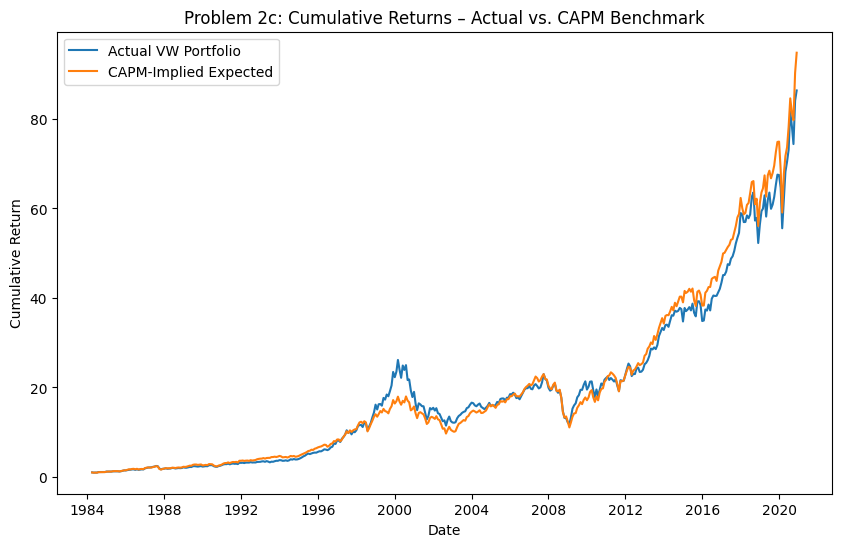

Beta: 1.0569944706131729


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1) Recompute your VW series (if not already in memory)
all_vw = []
for period in periods:
    vw = make_portfolio_returns(
        crsp,
        period['permnos'],
        period['start'],
        period['end'],
        equal=False
    )
    all_vw.append(vw)
vw_series = pd.concat(all_vw).sort_index()

# 2) Fit a CAPM on VW excess returns
df_capm = pd.concat([vw_series.rename('Rp'), factors], axis=1).dropna()
y = df_capm['Rp'] - df_capm['RF']
X = sm.add_constant(df_capm['Mkt-RF'])
capm_vw = sm.OLS(y, X).fit()
alpha, beta = capm_vw.params['const'], capm_vw.params['Mkt-RF']

# 3) Compute the CAPM‐implied expected return each month:
#    E[Rp] = Rf + α + β*(Mkt–Rf)
exp_excess = alpha + beta * df_capm['Mkt-RF']
exp_Rp     = exp_excess + df_capm['RF']

# 4) Build cumulative‐return series
cum_actual   = (1 + df_capm['Rp']).cumprod()
cum_expected = (1 + exp_Rp).cumprod()

# 5) Plot them together
plt.figure(figsize=(10,6))
plt.plot(cum_actual.index,   cum_actual,   label='Actual VW Portfolio')
plt.plot(cum_expected.index, cum_expected, label='CAPM-Implied Expected')
plt.legend()
plt.title('Problem 2c: Cumulative Returns – Actual vs. CAPM Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show() 

# For Question 3
print(f'Beta: {beta}')


In [20]:
import pandas as pd
import statsmodels.api as sm

# 1) Define subsamples around Jan 1, 2010
eq_pre  = eq_series[eq_series.index < '2010-01-01']
eq_post = eq_series[eq_series.index >= '2010-01-01']
vw_pre  = vw_series[vw_series.index < '2010-01-01']
vw_post = vw_series[vw_series.index >= '2010-01-01']

# 2) Regression helper for Carhart
def fit_carhart(r_ts):
    df = pd.concat([r_ts.rename('Rp'), factors], axis=1).dropna()
    y  = df['Rp'] - df['RF']
    X  = sm.add_constant(df[['Mkt-RF','SMB','HML','Mom']])
    return sm.OLS(y, X).fit()

# 3) Fit on each subsample
models = {
    'EW Pre-2010':  fit_carhart(eq_pre),
    'EW Post-2010': fit_carhart(eq_post),
    'VW Pre-2010':  fit_carhart(vw_pre),
    'VW Post-2010': fit_carhart(vw_post)
}

# 4) Summarize results
rows = []
for name, res in models.items():
    rows.append({
        'Subsample': name,
        'Alpha (%)': res.params['const'] * 100,
        't-stat':    res.tvalues['const'],
        'p-value':   res.pvalues['const']
    })

summary = pd.DataFrame(rows).set_index('Subsample').round(3)
print(summary)


              Alpha (%)  t-stat  p-value
Subsample                               
EW Pre-2010       0.215   2.356    0.019
EW Post-2010     -0.084  -0.550    0.583
VW Pre-2010       0.335   2.803    0.005
VW Post-2010     -0.201  -1.195    0.234


## Question 3

(a) You should find that the beta of this strategy is close to 1. Why is this the case? Suppose you create a long-short by shorting the overall market. Why might this be more attractive to institutional investors? Why might it be less attractive to retail investors?

We found the beta of this strategy to be 1.05699. Our portfolio moves slightly more than the market (5% more). GThe strategy invests mostly in large companies that are already part of major market indices. Due to this, the portfolio inherits market wide risk, causing the beta to be near 1. Shorting the overall market against the long position in the list would mostly remove market exposure (beta ≈ 0) and isolate the alpha of the strategy, This is very attractuve to institutional investors as it produces alpha while limiting downside risk as they are heavily levered. This is less attractuve to retail investors who are less-levered (if at all), and likely would prefer simple long-only strategies.


(b) Explain why these results show that financial markets do not fully price the value of employee satisfaction.

These result show that financial markets do not fully price the value of employee satisfaction since the results of the strategy show statistically significant alpha even after controlling for strandard risk factors (size, value, etc.)/ This suggetss that ocmpanies wiht high employee satisfaction ratings consistently outperform what traditional assset pricing models would predict. Thus, the financial markets do not fully incorporate the value of employee satisfaction into the stock prices.


(c) Why do you think the alpha has disappeared over time?

The alpha has likely disappeared over time since the strategy became widely known and utilized in the market. As investors recognized the link between employee satisfaction and stock performance, these factors became priced in eliminating the alpha. Additionally, improvements in data availability likley reduced the opportunity for alpha.


(d) The Best Companies to Work For list is valuable information. BCW surveys employees and produces information about employee satisfaction. In a sense, this is a somewhat antiquated way of producing information, and it is provided with a considerable time lag. We live in a world where each of us leaves a digital footprint, and the company Bombora purchases and aggregates cookie data from large media companies, and through email data stored in cookies they identify unique company employees. They can track what employees are reading about in real time. How might the employee satisfaction strategy be improved for the modern world?

The current strategy could be improved by utilizing the data from Bombora. Currently, the data is up to the discretion of the employee whether they submit the survey (or even if forced, the quality of the responses). Additionally, these surveys lag behind current productivity and satisfaction since they take time to collect. By utilizing the real time data from Bombora, companies could aggregage browsing behaivor, social media activity, professional networking, and other indicators to allow investors to detect shifts in employee satisfaction immediately.